## Set up Dataset

In [2]:
import datasets as datasets
import models as models
import losses as losses
import utils
import config as cf
import torch

import pickle
import os

config = cf.read_json("../experiments/exp_r4_linear_output/triplet_ge_first/config.json")
config['exp_dir'] = os.path.join(config["trainer"]["base_exp_dir"], config["model_name"])
torch.cuda.set_device(config['device_num'])

# Load Train Dataset
if "precomputed_train" in config['dataset']:
    train_dataset = pickle.load(open(config['dataset']["precomputed_train"], "rb"))
elif "save_train" in config['dataset']:
    train_dataset = pickle.load(open(config['dataset']["save_train"], "rb"))
else:
    train_dataset = cf.initialize_from_config(config, 'dataset', datasets)

if "precomputed_val" in config['dataset']:
    val_dataset = pickle.load(open(config['dataset']["precomputed_val"], "rb"))
elif "save_val" in config['dataset']:
    val_dataset = pickle.load(open(config['dataset']["save_val"], "rb"))
else:
    val_dataset = cf.initialize_from_config(config, 'dataset', datasets, split="val")

train_loader = cf.initialize_from_config(config, 'data_loader', torch.utils.data, train_dataset, shuffle=True)
val_loader = cf.initialize_from_config(config, 'data_loader', torch.utils.data, val_dataset)

# Wrappers for embedding evaluation
ge_wrapper_train = cf.initialize_from_config(config, 'dataset_wrapper_ge', datasets, train_dataset)
ge_wrapper_val = cf.initialize_from_config(config, 'dataset_wrapper_ge', datasets, val_dataset)
smiles_wrapper_train = cf.initialize_from_config(config, 'dataset_wrapper_smiles', datasets, train_dataset)
smiles_wrapper_val = cf.initialize_from_config(config, 'dataset_wrapper_smiles', datasets, val_dataset)

uniq_train_perts = set(smiles_wrapper_train.pert_smiles)
uniq_val_perts = set(smiles_wrapper_val.pert_smiles)

ge_loader_train = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, ge_wrapper_train)
ge_loader_val = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, ge_wrapper_val)
smiles_loader_train = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, smiles_wrapper_train)
smiles_loader_val = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, smiles_wrapper_val)

### Load Model

In [3]:
import torch
import torch.nn as nn
import sys

model = torch.load("../experiments/exp_r3_act_embed/triplet_ge_first/checkpoint_triplet_ge_first_95_val_mrr=0.08731826.pth")

/home/anaconda/anaconda3/envs/siamese/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'models.FeedForwardTripletNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/anaconda/anaconda3/envs/siamese/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'models.SNN_Embedder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [144]:
chemprop_model_pretrained = models.load_chemprop_model("/home/sgf2/DBMI_server/repo/chemprop/pcba/model_unoptimized.pt")

In [303]:
import numpy as np

def get_embeddings(model, ge_wrapper, ge_loader, smiles_wrapper, smiles_loader):
    gex_raw = np.zeros([ge_wrapper.__len__(), ge_wrapper.__getitem__(0)[0].shape[0]])
    gex_embeddings = np.zeros([ge_wrapper.__len__(), model.embed_size])
    smiles_gex_labels = []
    smiles_chem_labels = []
    chem_embeddings = np.zeros([smiles_wrapper.__len__(), model.embed_size])
    
    if 'rdkit_features' in config and config['rdkit_features']:
        nfeats_chemprop = 2400
    else:
        nfeats_chemprop = 300
    chem_embeddings_chemprop = np.zeros([smiles_wrapper.__len__(), nfeats_chemprop])
    # smiles_strings = smiles_wrapper.pert_smiles

    model.eval()
    with torch.no_grad():
        # GE embeds for all of train
        for i, batch in enumerate(ge_loader):
            gex = batch[0].cuda()
            start_ind = i * ge_loader.batch_size
            end_ind = start_ind + gex.shape[0]

            smiles_gex_labels.extend(batch[1])
            gex_embeddings[start_ind:end_ind, :] = model.ge_embed(gex).cpu().numpy()
            gex_raw[start_ind:end_ind, :] = gex.cpu().numpy()

        # Embeds for all unique chems
        for i, batch in enumerate(smiles_loader):
            smiles = batch
            smiles_chem_labels.extend(batch)
            start_ind = i * smiles_loader.batch_size
            end_ind = start_ind + len(smiles)
            if 'rdkit_features' in config and config['rdkit_features']:
                feats = [smiles_to_feats[x] for x in smiles]
                chem_embeds = model.chem_linear(model.chemprop_encoder(smiles, feats))
                chem_embeds_chemprop = chemprop_model_pretrained(smiles, feats)
            else:
                chem_embeds = model.chem_linear(model.chemprop_encoder(smiles))
                chem_embeds_chemprop = chemprop_model_pretrained(smiles)
            chem_embeddings[start_ind:end_ind, :] = chem_embeds.cpu().numpy()
            chem_embeddings_chemprop[start_ind:end_ind, :] = chem_embeds_chemprop.cpu().numpy()
            
    # Embeddings for all chems in train
    smile_to_chem = {}
    smile_to_chem_cp = {}
    for i, smile in enumerate(smiles_chem_labels):
        smile_to_chem[smile] = chem_embeddings[i,:]
        smile_to_chem_cp[smile] = chem_embeddings_chemprop[i,:]

    chem_embeddings_all = []
    chem_embeddings_all_chemprop = []
    for smile in smiles_gex_labels:
        chem_embeddings_all.append(smile_to_chem[smile])
        chem_embeddings_all_chemprop.append(smile_to_chem_cp[smile])
    chem_embeddings_all = np.stack(chem_embeddings_all)
    chem_embeddings_all_chemprop = np.stack(chem_embeddings_all_chemprop)

    return gex_raw, gex_embeddings, chem_embeddings_all, chem_embeddings, chem_embeddings_all_chemprop, chem_embeddings_chemprop, np.array(smiles_gex_labels), np.array(smiles_chem_labels)

In [304]:
gex_raw, gex_embeddings, chem_embeddings, chem_embeddings_unique, chem_embeddings_chemprop, chem_embeddings_unique_chemprop, smiles_gex_labels, smiles_chem_labels = get_embeddings(model, ge_wrapper_val, ge_loader_val, smiles_wrapper_val, smiles_loader_val)
gex_raw.shape, gex_embeddings.shape, chem_embeddings.shape, chem_embeddings_unique.shape, chem_embeddings_chemprop.shape, chem_embeddings_unique_chemprop.shape, len(smiles_gex_labels), len(smiles_chem_labels)

((2642, 2934),
 (2642, 128),
 (2642, 128),
 (2248, 128),
 (2642, 300),
 (2248, 300),
 2642,
 2248)

In [305]:
gex_raw_train, gex_embeddings_train, chem_embeddings_train, chem_embeddings_unique_train, chem_embeddings_chemprop_train, chem_embeddings_unique_chemprop_train, smiles_gex_labels_train, smiles_chem_labels_train = get_embeddings(model, ge_wrapper_train, ge_loader_train, smiles_wrapper_train, smiles_loader_train)
gex_raw_train.shape, gex_embeddings_train.shape, chem_embeddings_train.shape, chem_embeddings_unique_train.shape , chem_embeddings_chemprop_train.shape, chem_embeddings_unique_chemprop_train.shape, len(smiles_gex_labels_train), len(smiles_chem_labels_train)

((29548, 2934),
 (29548, 128),
 (29548, 128),
 (6318, 128),
 (29548, 300),
 (6318, 300),
 29548,
 6318)

In [62]:
import pandas as pd
gex_embeddings_mean_pd = pd.DataFrame(data=gex_embeddings, index = smiles_gex_labels).rename_axis(index=['smiles']).groupby('smiles').mean()
chem_embeddings_mean_pd = pd.DataFrame(data=chem_embeddings_unique, index = smiles_chem_labels ).rename_axis(index=['smiles']).groupby('smiles').mean()
assert(all(gex_embeddings_mean_pd.index.values == chem_embeddings_mean_pd.index.values))

## Tanimoto similarity

In [66]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import MolFromSmiles,AllChem


In [197]:
ms = [MolFromSmiles(x) for x in smiles_gex_labels]
fingerprints = np.stack([AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=128) for x in ms])

ms = [MolFromSmiles(x) for x in smiles_chem_labels]
fingerprints_unique = np.stack([AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=128) for x in ms])

ms_train = [MolFromSmiles(x) for x in smiles_gex_labels_train]
fingerprints_train = np.stack([AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=128) for x in ms_train])

fingerprints.shape, fingerprints_unique.shape, fingerprints_train.shape

((2642, 128), (2248, 128), (29548, 128))

## Ranking Evaluation

In [309]:
from scipy.stats.mstats import rankdata

def get_ind_first_match(smiles_gex_labels, smiles_chem_labels):
    inds_first_match = []
    for i, sml in enumerate(smiles_gex_labels):
        match = np.where(smiles_chem_labels == sml)[0]
    rank_first_match = np.array(rank_first_match).squeeze()
    inds_first_match = np.array(inds_first_match).squeeze()
    return inds_first_match

def get_ranks_first_match(gex_chem_ranks, smiles_gex_labels, smiles_chem_labels):
    rank_first_match = []
    for i, sml in enumerate(smiles_gex_labels):
        matches = np.where(smiles_chem_labels == sml)[0]
        ranks_matches = gex_chem_ranks[i, matches]
        rank_first_match.append(np.min(ranks_matches))
    rank_first_match = np.array(rank_first_match).squeeze()
    return rank_first_match

def prepare_metrics(rank_first_match, indices):
    median_rank = np.median(rank_first_match[indices])
    mrr = np.mean(1 / rank_first_match[indices])
    hits_at_10 = np.mean(
        [np.sum(results <= 10) for results in rank_first_match[indices]])  # can change to rank_all_matches
    hits_at_100 = np.mean([np.sum(results <= 100) for results in rank_first_match[indices]])
    hits_at_500 = np.mean([np.sum(results <= 500) for results in rank_first_match[indices]])
    return {#"total_drugs": len(set(np.array(smiles_gex_labels)[inds])),
            "median_rank": median_rank,
            "MRR": mrr,
            "H@10": hits_at_10,
            "H@100": hits_at_100,
            "H@500": hits_at_500
        }

def get_val_scores(distmat,
                   smiles_gex_labels=smiles_gex_labels,
                   smiles_chem_labels=smiles_chem_labels,
                   train_smiles = list(set(smiles_chem_labels_train))):

    gex_chem_ranks = rankdata(distmat, axis=1)

    rank_first_match_all = get_ranks_first_match(gex_chem_ranks, smiles_gex_labels, smiles_chem_labels)

    list_of_inds = [[i for i,j in enumerate(smiles_gex_labels)]]
    ge_inds_in_train = [i for i, j in enumerate(smiles_gex_labels) if j in train_smiles]
    ge_inds_not_in_train = [i for i, j in enumerate(smiles_gex_labels) if j not in train_smiles]
    list_of_inds.append(ge_inds_in_train)
    list_of_inds.append(ge_inds_not_in_train)

    chem_inds_not_in_train = [i for i,j in enumerate(smiles_chem_labels) if j not in train_smiles]

    ir_results = []
    for inds in list_of_inds:
        ir_results.append(prepare_metrics(rank_first_match_all, inds))

    ranks_subset = rankdata(gex_chem_ranks[:, chem_inds_not_in_train][ge_inds_not_in_train,:], axis=1)
    rank_first_match = get_ranks_first_match(ranks_subset,
                                             smiles_gex_labels[ge_inds_not_in_train],
                                             smiles_chem_labels[chem_inds_not_in_train])
    ir_results.append(prepare_metrics(rank_first_match,
                                      [k for k in range(len(ge_inds_not_in_train))]
                                      ))
    val_print_labels = ["Val (All):              ", "Val (In Train):         ",
                            "Val (Not in Train):     ", "Val (No train, limited):"]
    for i, res_dict in enumerate(ir_results):
        print(val_print_labels[i] + "    ".join(['{}: {:.3f}'.format(k, res_dict[k]) for k in res_dict]))

    match_dists = []
    nonmatch_dists = []
    for i, sml in enumerate(smiles_gex_labels):
        match = np.where(smiles_chem_labels == sml)[0]
        match_dists.append(distmat[i,match[0]])
        nonmatch_dists.extend( list(distmat[i,:match[0]]) + list(distmat[i,match[0]+1:]) )
    match_sims = 1-np.array(match_dists)
    nonmatch_sims = 1-np.array(nonmatch_dists)
    
    print("Average correlation between matched GE and Chem embeds (CCA):   ", np.mean(match_sims))
    print("Average correlation between unmatched GE and Chem embeds (CAA): ", np.mean(nonmatch_sims))
    print("Difference: ", np.mean(match_sims) - np.mean(nonmatch_sims) )
    print()
    
    sns.distplot(match_sims)
    sns.distplot(nonmatch_sims)
        
    return rank_first_match_all, rank_first_match, match_sims, nonmatch_sims

from sklearn.cross_decomposition import CCA
def cca_cor(ncomp = 50,
            embeds_ge_train=gex_embeddings_train, embeds_ge_val=gex_embeddings,
            embeds_chem_train=chem_embeddings_train, embeds_chem_val=chem_embeddings,
            embeds_chem_uniq_val=chem_embeddings_unique
           ):
    print("CCA w/", ncomp, "components")
    cca = CCA(n_components=ncomp, max_iter = 1000)
    cca.fit(embeds_ge_train, embeds_chem_train)
    cca_gex_val, cca_chem_val = cca.transform(embeds_ge_val, embeds_chem_uniq_val)

    print("Computing Distances")
    gex_chem_embed_dist_cca = cdist(cca_gex_val, cca_chem_val,  metric='correlation')
    ranks_val_all, ranks_val_out, match_sims, nonmatch_sims = get_val_scores(gex_chem_embed_dist_cca)
    return ranks_val_all, ranks_val_out, match_sims, nonmatch_sims

## N Components Experiment

CCA w/ 5 components
Computing Distances
Val (All):              median_rank: 293.000    MRR: 0.026    H@10: 0.058    H@100: 0.288    H@500: 0.633
Val (In Train):         median_rank: 264.000    MRR: 0.029    H@10: 0.063    H@100: 0.310    H@500: 0.652
Val (Not in Train):     median_rank: 516.000    MRR: 0.010    H@10: 0.013    H@100: 0.123    H@500: 0.490
Val (No train, limited):median_rank: 99.500    MRR: 0.033    H@10: 0.081    H@100: 0.503    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.5749789271033009
Average correlation between unmatched GE and Chem embeds (CAA):  0.03782827312567362
Difference:  0.5371506539776273



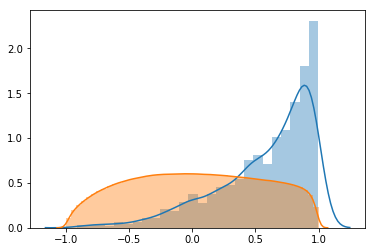

In [329]:
ranks_val_cca_all_5, ranks_val_cca_out_5, simsM_cca_all_5, simsNM_cca_all_5 = cca_cor(5)

CCA w/ 10 components
Computing Distances
Val (All):              median_rank: 240.500    MRR: 0.061    H@10: 0.109    H@100: 0.343    H@500: 0.689
Val (In Train):         median_rank: 207.500    MRR: 0.068    H@10: 0.121    H@100: 0.370    H@500: 0.713
Val (Not in Train):     median_rank: 493.500    MRR: 0.013    H@10: 0.019    H@100: 0.143    H@500: 0.506
Val (No train, limited):median_rank: 94.000    MRR: 0.045    H@10: 0.088    H@100: 0.523    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.511154895183748
Average correlation between unmatched GE and Chem embeds (CAA):  0.03192415670479188
Difference:  0.47923073847895614



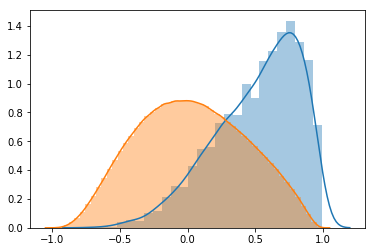

In [330]:
ranks_val_cca_all_10, ranks_val_cca_out_10, simsM_cca_all_10, simsNM_cca_all_10 = cca_cor(10)

CCA w/ 15 components
Computing Distances
Val (All):              median_rank: 221.500    MRR: 0.078    H@10: 0.139    H@100: 0.366    H@500: 0.712
Val (In Train):         median_rank: 189.000    MRR: 0.086    H@10: 0.154    H@100: 0.395    H@500: 0.737
Val (Not in Train):     median_rank: 487.000    MRR: 0.011    H@10: 0.026    H@100: 0.146    H@500: 0.523
Val (No train, limited):median_rank: 97.000    MRR: 0.047    H@10: 0.084    H@100: 0.506    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.4741708575034379
Average correlation between unmatched GE and Chem embeds (CAA):  0.028991821427878612
Difference:  0.4451790360755593



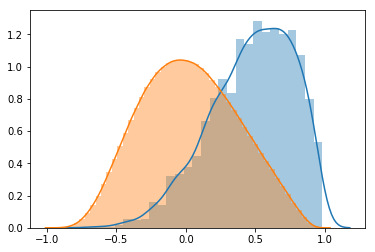

In [331]:
ranks_val_cca_all_15, ranks_val_cca_out_15, simsM_cca_all_15, simsNM_cca_all_15 = cca_cor(15)

CCA w/ 20 components
Computing Distances
Val (All):              median_rank: 223.000    MRR: 0.084    H@10: 0.142    H@100: 0.371    H@500: 0.709
Val (In Train):         median_rank: 183.000    MRR: 0.094    H@10: 0.158    H@100: 0.402    H@500: 0.737
Val (Not in Train):     median_rank: 505.000    MRR: 0.010    H@10: 0.023    H@100: 0.133    H@500: 0.497
Val (No train, limited):median_rank: 101.000    MRR: 0.046    H@10: 0.088    H@100: 0.497    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.44091589392069636
Average correlation between unmatched GE and Chem embeds (CAA):  0.026902784036755972
Difference:  0.41401310988394036



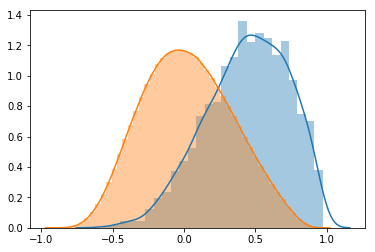

In [332]:
ranks_val_cca_all_20, ranks_val_cca_out_20, simsM_cca_all_20, simsNM_cca_all_20 = cca_cor(20)

CCA w/ 25 components
Computing Distances
Val (All):              median_rank: 207.000    MRR: 0.088    H@10: 0.151    H@100: 0.383    H@500: 0.714
Val (In Train):         median_rank: 171.000    MRR: 0.098    H@10: 0.168    H@100: 0.413    H@500: 0.744
Val (Not in Train):     median_rank: 515.500    MRR: 0.013    H@10: 0.023    H@100: 0.153    H@500: 0.484
Val (No train, limited):median_rank: 98.500    MRR: 0.055    H@10: 0.120    H@100: 0.506    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.42024047727627045
Average correlation between unmatched GE and Chem embeds (CAA):  0.024365628427587827
Difference:  0.3958748488486826



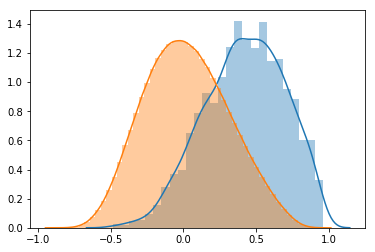

In [333]:
ranks_val_cca_all_25, ranks_val_cca_out_25, simsM_cca_all_25, simsNM_cca_all_25 = cca_cor(25)

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 189.000    MRR: 0.100    H@10: 0.171    H@100: 0.391    H@500: 0.719
Val (In Train):         median_rank: 155.500    MRR: 0.112    H@10: 0.190    H@100: 0.422    H@500: 0.743
Val (Not in Train):     median_rank: 451.000    MRR: 0.015    H@10: 0.032    H@100: 0.159    H@500: 0.539
Val (No train, limited):median_rank: 104.000    MRR: 0.058    H@10: 0.120    H@100: 0.477    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.34320230977765254
Average correlation between unmatched GE and Chem embeds (CAA):  0.01837906189917049
Difference:  0.32482324787848205



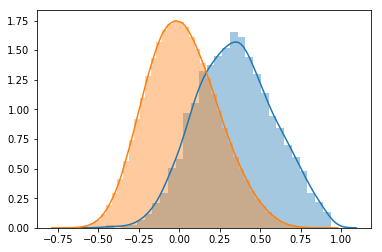

In [334]:
ranks_val_cca_all_50, ranks_val_cca_out_50, simsM_cca_all_50, simsNM_cca_all_50 = cca_cor(50)

CCA w/ 75 components
Computing Distances
Val (All):              median_rank: 203.500    MRR: 0.102    H@10: 0.176    H@100: 0.388    H@500: 0.712
Val (In Train):         median_rank: 167.000    MRR: 0.113    H@10: 0.196    H@100: 0.422    H@500: 0.736
Val (Not in Train):     median_rank: 465.000    MRR: 0.017    H@10: 0.029    H@100: 0.130    H@500: 0.529
Val (No train, limited):median_rank: 108.500    MRR: 0.058    H@10: 0.107    H@100: 0.471    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.29572817873467705
Average correlation between unmatched GE and Chem embeds (CAA):  0.01553254743554963
Difference:  0.28019563129912745



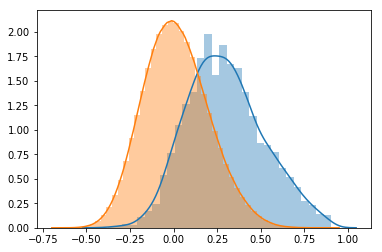

In [335]:
ranks_val_cca_all_75, ranks_val_cca_out_75, simsM_cca_all_75, simsNM_cca_all_75 = cca_cor(75)

CCA w/ 100 components
Computing Distances
Val (All):              median_rank: 208.500    MRR: 0.103    H@10: 0.171    H@100: 0.392    H@500: 0.709
Val (In Train):         median_rank: 166.000    MRR: 0.114    H@10: 0.191    H@100: 0.426    H@500: 0.731
Val (Not in Train):     median_rank: 456.500    MRR: 0.014    H@10: 0.023    H@100: 0.133    H@500: 0.539
Val (No train, limited):median_rank: 103.000    MRR: 0.055    H@10: 0.101    H@100: 0.490    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.26733612887693936
Average correlation between unmatched GE and Chem embeds (CAA):  0.01376421560963079
Difference:  0.25357191326730855



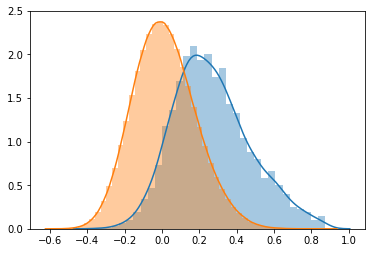

In [336]:
ranks_val_cca_all_100, ranks_val_cca_out_100, simsM_cca_all_100, simsNM_cca_all_100 = cca_cor(100)

CCA w/ 125 components
Computing Distances
Val (All):              median_rank: 204.500    MRR: 0.100    H@10: 0.169    H@100: 0.396    H@500: 0.707
Val (In Train):         median_rank: 169.000    MRR: 0.111    H@10: 0.189    H@100: 0.428    H@500: 0.729
Val (Not in Train):     median_rank: 464.000    MRR: 0.014    H@10: 0.019    H@100: 0.153    H@500: 0.539
Val (No train, limited):median_rank: 106.000    MRR: 0.052    H@10: 0.101    H@100: 0.477    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.24376033426838378
Average correlation between unmatched GE and Chem embeds (CAA):  0.012259380665061194
Difference:  0.2315009536033226



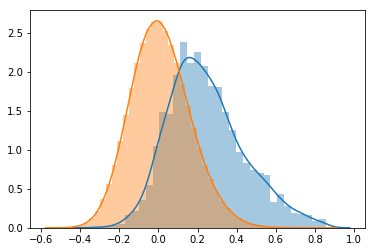

In [337]:
ranks_val_cca_all_125, ranks_val_cca_out_125, simsM_cca_all_125, simsNM_cca_all_125 = cca_cor(125)

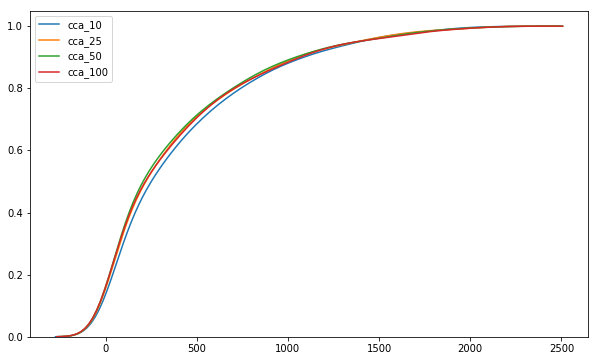

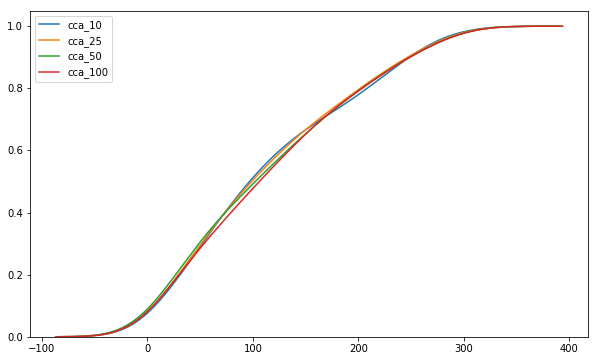

In [326]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
#sns.kdeplot(ranks_val_cca_all_5, cumulative=True, label = 'cca_5')
sns.kdeplot(ranks_val_cca_all_10, cumulative=True, label = 'cca_10')
#sns.kdeplot(ranks_val_cca_all_15, cumulative=True, label = 'cca_15')
#sns.kdeplot(ranks_val_cca_all_20, cumulative=True, label = 'cca_20')
sns.kdeplot(ranks_val_cca_all_25, cumulative=True, label = 'cca_25')
sns.kdeplot(ranks_val_cca_all_50, cumulative=True, label = 'cca_50')
#sns.kdeplot(ranks_val_cca_all_75, cumulative=True, label = "cca_75")
sns.kdeplot(ranks_val_cca_all_100, cumulative=True, label = "cca_100")
#sns.kdeplot(ranks_val_cca_all_125, cumulative=True, label = "cca_125")
plt.show()

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
#sns.kdeplot(ranks_val_cca_out_5, cumulative=True, label = 'cca_5')
sns.kdeplot(ranks_val_cca_out_10, cumulative=True, label = 'cca_10')
#sns.kdeplot(ranks_val_cca_out_15, cumulative=True, label = 'cca_15')
#sns.kdeplot(ranks_val_cca_out_20, cumulative=True, label = 'cca_20')
sns.kdeplot(ranks_val_cca_out_25, cumulative=True, label = 'cca_25')
sns.kdeplot(ranks_val_cca_out_50, cumulative=True, label = 'cca_50')
#sns.kdeplot(ranks_val_cca_out_75, cumulative=True, label = "cca_75")
sns.kdeplot(ranks_val_cca_out_100, cumulative=True, label = "cca_100")
#sns.kdeplot(ranks_val_cca_out_125, cumulative=True, label = "cca_125")
plt.show()

## Test set Numbers

In [ ]:
test_dataset = cf.initialize_from_config(config, 'dataset', datasets, split="test")

In [ ]:
test_dataset.__len__()

In [ ]:
len(set(train_dataset.pert_smiles)), len(set(val_dataset.pert_smiles)), len(set(test_dataset.pert_smiles))

In [ ]:
len(set(val_dataset.pert_smiles).difference(set(train_dataset.pert_smiles))), len(set(test_dataset.pert_smiles).difference(set(train_dataset.pert_smiles)))

## Testing IR code on val set

In [292]:
gex_raw.shape, gex_embeddings.shape, chem_embeddings.shape, chem_embeddings_unique.shape, len(smiles_gex_labels), len(smiles_chem_labels)

((2642, 2934), (2642, 128), (2642, 128), (2248, 128), 2642, 2248)

Original
Val (All):              median_rank: 188.500    MRR: 0.083    H@10: 0.147    H@100: 0.379    H@500: 0.719
Val (In Train):         median_rank: 165.500    MRR: 0.092    H@10: 0.164    H@100: 0.407    H@500: 0.738
Val (Not in Train):     median_rank: 384.000    MRR: 0.014    H@10: 0.019    H@100: 0.169    H@500: 0.575
Val (No train, limited):median_rank: 79.500    MRR: 0.054    H@10: 0.104    H@100: 0.565    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.69548010802602
Average correlation between unmatched GE and Chem embeds (CAA):  0.4632861477478392
Difference:  0.2321939602781808



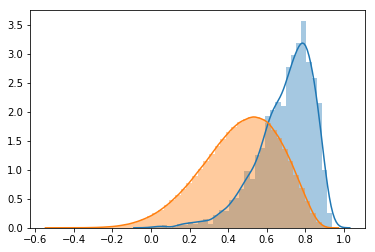

In [301]:
print("Original")
gex_chem_baseline_dist = cdist(gex_embeddings, chem_embeddings_unique,  metric='correlation')
ranks_val_orig_all, ranks_val_orig_out, simsM_orig_all, simsNM_orig_all = get_val_scores(gex_chem_baseline_dist)

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 556.000    MRR: 0.062    H@10: 0.097    H@100: 0.221    H@500: 0.479
Val (In Train):         median_rank: 494.000    MRR: 0.069    H@10: 0.109    H@100: 0.238    H@500: 0.501
Val (Not in Train):     median_rank: 969.000    MRR: 0.004    H@10: 0.006    H@100: 0.094    H@500: 0.315
Val (No train, limited):median_rank: 143.500    MRR: 0.028    H@10: 0.052    H@100: 0.373    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.13716768981802108
Average correlation between unmatched GE and Chem embeds (CAA):  0.0068723863251815495
Difference:  0.13029530349283952



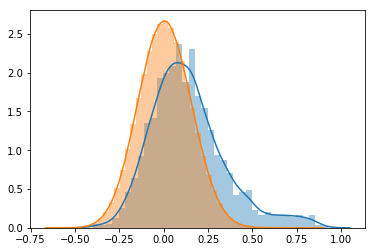

In [311]:
ranks_val_geEmbed_fps_all, ranks_val_geEmbed_fps_out, simsM_geEmbed_fps_all, simsNM_geEmbed_fps_all = cca_cor(ncomp = 50,
                                                                                                              embeds_chem_train=fingerprints_train,
                                                                                                              embeds_chem_val=fingerprints,
                                                                                                              embeds_chem_uniq_val=fingerprints_unique)

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 324.000    MRR: 0.078    H@10: 0.132    H@100: 0.316    H@500: 0.590
Val (In Train):         median_rank: 292.500    MRR: 0.087    H@10: 0.147    H@100: 0.341    H@500: 0.610
Val (Not in Train):     median_rank: 606.000    MRR: 0.012    H@10: 0.016    H@100: 0.120    H@500: 0.438
Val (No train, limited):median_rank: 102.000    MRR: 0.042    H@10: 0.058    H@100: 0.490    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.20306076847397742
Average correlation between unmatched GE and Chem embeds (CAA):  0.008042611999530842
Difference:  0.19501815647444656



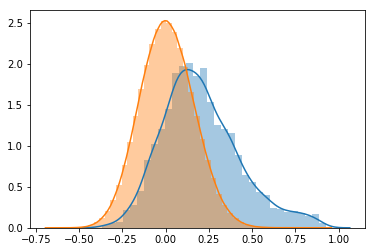

In [312]:
ranks_val_geEmbed_chemprop_all, ranks_val_geEmbed_chemprop_out, simsM_geEmbed_chemprop_all, simsNM_geEmbed_chemprop_all = cca_cor(ncomp = 50,
                                                                                                                                  embeds_chem_train=chem_embeddings_chemprop_train,
                                                                                                                                  embeds_chem_val=chem_embeddings_chemprop,
                                                                                                                                  embeds_chem_uniq_val=chem_embeddings_unique_chemprop
                                                                                                                         )

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 189.000    MRR: 0.100    H@10: 0.171    H@100: 0.391    H@500: 0.719
Val (In Train):         median_rank: 155.500    MRR: 0.112    H@10: 0.190    H@100: 0.422    H@500: 0.743
Val (Not in Train):     median_rank: 451.000    MRR: 0.015    H@10: 0.032    H@100: 0.159    H@500: 0.539
Val (No train, limited):median_rank: 104.000    MRR: 0.058    H@10: 0.120    H@100: 0.477    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.34320230977765254
Average correlation between unmatched GE and Chem embeds (CAA):  0.01837906189917049
Difference:  0.32482324787848205



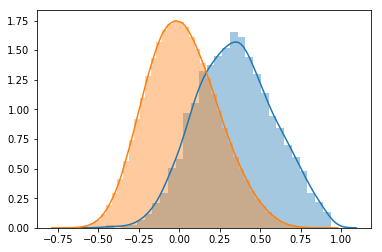

In [310]:
ranks_val_cca_all, ranks_val_cca_out, simsM_cca_all, simsNM_cca_all = cca_cor()

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 722.000    MRR: 0.058    H@10: 0.087    H@100: 0.182    H@500: 0.402
Val (In Train):         median_rank: 700.500    MRR: 0.064    H@10: 0.097    H@100: 0.199    H@500: 0.416
Val (Not in Train):     median_rank: 898.500    MRR: 0.010    H@10: 0.013    H@100: 0.055    H@500: 0.295
Val (No train, limited):median_rank: 134.500    MRR: 0.032    H@10: 0.052    H@100: 0.396    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.10175339147572571
Average correlation between unmatched GE and Chem embeds (CAA):  0.0017169179588513485
Difference:  0.10003647351687436



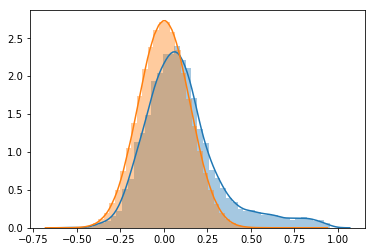

In [313]:
ranks_val_rawGE_fps_all, ranks_val_rawGE_fps_out, simsM_rawGE_fps_all, simsNM_rawGE_fps_all = cca_cor(ncomp = 50,
                                                           embeds_ge_train=gex_raw_train[:,-978:],
                                                           embeds_chem_train=fingerprints_train,
                                                           embeds_ge_val=gex_raw[:,-978:],
                                                           embeds_chem_val=fingerprints,
                                                           embeds_chem_uniq_val=fingerprints_unique)

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 533.500    MRR: 0.075    H@10: 0.115    H@100: 0.248    H@500: 0.483
Val (In Train):         median_rank: 501.500    MRR: 0.082    H@10: 0.125    H@100: 0.260    H@500: 0.500
Val (Not in Train):     median_rank: 766.500    MRR: 0.020    H@10: 0.042    H@100: 0.156    H@500: 0.354
Val (No train, limited):median_rank: 111.000    MRR: 0.057    H@10: 0.101    H@100: 0.468    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.14671522851528795
Average correlation between unmatched GE and Chem embeds (CAA):  0.002903714198383301
Difference:  0.14381151431690464



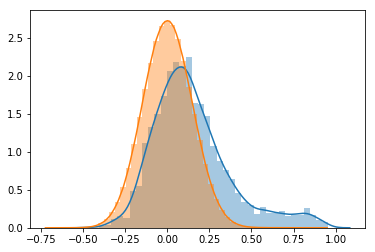

In [314]:
ranks_val_rawGE_chemprop_all, ranks_val_rawGE_chemprop_out, simsM_rawGE_chemprop_all, simsNM_rawGE_chemprop_all = cca_cor(ncomp = 50,
                                                                                                                          embeds_ge_train=gex_raw_train[:,-978:],
                                                                                                                          embeds_ge_val=gex_raw[:,-978:],
                                                                                                                          embeds_chem_train=chem_embeddings_chemprop_train,
                                                                                                                          embeds_chem_val=chem_embeddings_chemprop,
                                                                                                                          embeds_chem_uniq_val=chem_embeddings_unique_chemprop
                                                                                                                         )

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 365.500    MRR: 0.083    H@10: 0.142    H@100: 0.305    H@500: 0.570
Val (In Train):         median_rank: 328.000    MRR: 0.092    H@10: 0.156    H@100: 0.326    H@500: 0.591
Val (Not in Train):     median_rank: 687.000    MRR: 0.017    H@10: 0.039    H@100: 0.149    H@500: 0.409
Val (No train, limited):median_rank: 101.000    MRR: 0.062    H@10: 0.110    H@100: 0.497    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.1903238847939953
Average correlation between unmatched GE and Chem embeds (CAA):  0.0038355603890431684
Difference:  0.18648832440495214



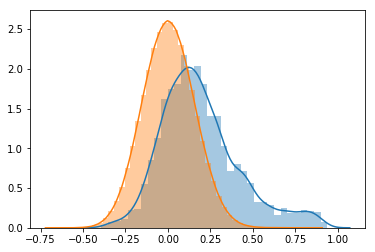

In [327]:
ranks_val_rawGE_chemEmbed_all, ranks_val_rawGE_chemEmbed_out, simsM_rawGE_chemEmbed_all, simsNM_rawGE_chemEmbed_all = cca_cor(ncomp = 50,
                                                                       embeds_ge_train=gex_raw_train[:,-978:],
                                                                       embeds_ge_val=gex_raw[:,-978:])

## Plots

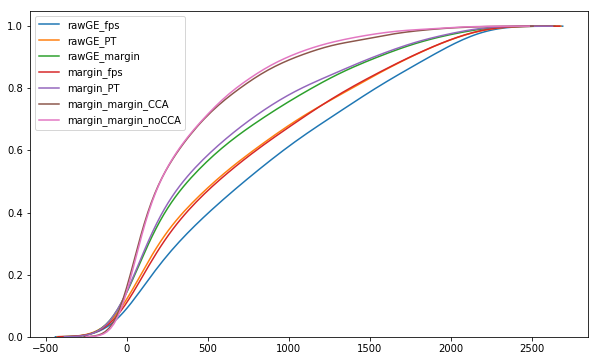

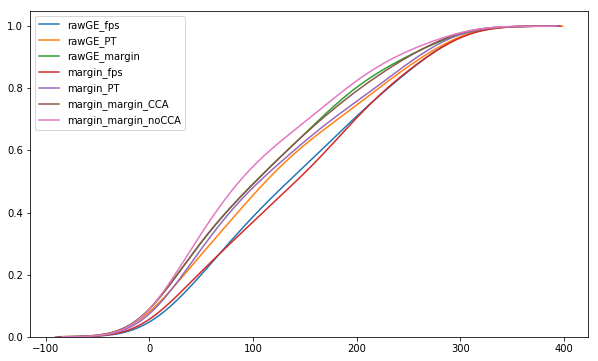

In [328]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
sns.kdeplot(ranks_val_rawGE_fps_all, cumulative=True, label = 'rawGE_fps')
sns.kdeplot(ranks_val_rawGE_chemprop_all, cumulative=True, label = 'rawGE_PT')
sns.kdeplot(ranks_val_rawGE_chemEmbed_all, cumulative=True, label = 'rawGE_margin')
sns.kdeplot(ranks_val_geEmbed_fps_all, cumulative=True, label = "margin_fps")
sns.kdeplot(ranks_val_geEmbed_chemprop_all, cumulative=True, label = "margin_PT")
sns.kdeplot(ranks_val_cca_all, cumulative=True, label = "margin_margin_CCA")
sns.kdeplot(ranks_val_orig_all, cumulative=True, label = "margin_margin_noCCA")
plt.show()

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
sns.kdeplot(ranks_val_rawGE_fps_out, cumulative=True, label = 'rawGE_fps')
sns.kdeplot(ranks_val_rawGE_chemprop_out, cumulative=True, label = 'rawGE_PT')
sns.kdeplot(ranks_val_rawGE_chemEmbed_out, cumulative=True, label = 'rawGE_margin')
sns.kdeplot(ranks_val_geEmbed_fps_out, cumulative=True, label = "margin_fps")
sns.kdeplot(ranks_val_geEmbed_chemprop_out, cumulative=True, label = "margin_PT")
sns.kdeplot(ranks_val_cca_out, cumulative=True, label = "margin_margin_CCA")
sns.kdeplot(ranks_val_orig_out, cumulative=True, label = "margin_margin_noCCA")
plt.show()